In [1]:
import copy
import os
import time

import joblib
from fastfusion import Specification
from fastfusion.frontend.architecture import Leaf, Memory
from fastfusion.mapper.FFM.exploration.mapper_multi_einsum import get_sims
from fastfusion.mapper.FFM.exploration.metrics import Metrics
from fastfusion.mapper.FFM.joining.sim import SIM
from fastfusion.mapper.FFM.joining.simexplore import join_sims
import fastfusion.mapper.FFM.exploration.mapper_one_einsum as mapper_one_einsum

from fastfusion.mapper.FFM.exploration.mapping_filter_tags.ffmt import get_ffmt_tag
from fastfusion.mapper.FFM.exploration.mapping_filter_tags.onesplit import get_one_split_tag
from fastfusion.mapper.FFM.pareto import PartialMappings
import pickle as pkl

metrics = Metrics.ENERGY
archname = "four_level"

@joblib.memory.Memory(location='./cache', verbose=2).cache
def get_fused_mappings(
    renames_name: str,
    glb_size_scale: float = 1.0,
    reg_x_y_scale: float = 1.0,
) -> PartialMappings:
    cachkey = f"./cache/{renames_name}_{glb_size_scale}_{reg_x_y_scale}.pkl"
    if os.path.exists(cachkey):
        return pkl.load(open(cachkey, "rb"))
    spec = Specification.from_yaml(
        f"architecture/{archname}.arch.yaml",
        f"workloads/mha_full.workload.yaml",
        f"workloads/mha_full{renames_name}.renames.yaml"
    )
    spec2 = copy.deepcopy(spec)
    glb: Memory = spec2.architecture.nodes["GlobalBuffer"]
    glb.attributes.size = f"round({glb.attributes.size} * {glb_size_scale})"
    glb.attributes.energy_scale = (glb_size_scale ** (1.56 / 2))
    llb: Memory = spec2.architecture.nodes["LocalBuffer"]
    llb.attributes.size = f"round({glb.attributes.size} * {glb_size_scale})"
    llb.attributes.energy_scale = (glb_size_scale ** (1.56 / 2))
    reg: Memory = spec2.architecture.nodes["Register"]
    reg.spatial.fanout["X"] = round(reg.spatial.fanout["X"] * reg_x_y_scale)
    reg.spatial.fanout["Y"] = round(reg.spatial.fanout["Y"] * reg_x_y_scale)

    spec2.estimate_energy_area()
    flattened_architecture = spec2.get_flattened_architecture()
    sims, decompress_data = get_sims(spec2, flattened_architecture, metrics=metrics)
    mappings = join_sims(sims, spec2, flattened_architecture)
    mappings.decompress(decompress_data)
    pkl.dump(mappings, open(cachkey, "wb"))
    return mappings

result = {
    # (0.25, "Fusion"): get_fused_mappings("", 0.25),
    # (0.5, "Fusion"): get_fused_mappings("", 0.5),
    # (1, "Fusion"): get_fused_mappings("", 1.0),
    # (2, "Fusion"): get_fused_mappings("", 2.0),
    # (4, "Fusion"): get_fused_mappings("", 4.0),
    (0.25, "No Fusion"): get_fused_mappings("_no_fusion", 0.25),
    (0.5, "No Fusion"): get_fused_mappings("_no_fusion", 0.5),
    (1, "No Fusion"): get_fused_mappings("_no_fusion", 1.0),
    (2, "No Fusion"): get_fused_mappings("_no_fusion", 2.0),
    (4, "No Fusion"): get_fused_mappings("_no_fusion", 4.0),
}
for k, v in result.items():
    print(f'{k}: {v.data["metric_Energy"].min()}')


INFO        Loading yaml file architecture/four_level.arch.yaml
INFO        Found top key variables in architecture/four_level.arch.yaml
INFO        Found top key architecture in architecture/four_level.arch.yaml
INFO        Found top key component_classes in architecture/four_level.arch.yaml
INFO        Loading yaml file workloads/mha_full.workload.yaml
INFO        Found top key workload in workloads/mha_full.workload.yaml
INFO        Loading yaml file workloads/mha_full_no_fusion.renames.yaml
INFO        Found top key renames in workloads/mha_full_no_fusion.renames.yaml
WARNING     Loading configuration file from /root/.config/fastfusion/config.yaml
INFO        Calculated "round(1024*1024*128*8 * 0.5)" = 536870912.
INFO        Calculated "round(round(1024*1024*128*8 * 0.5) * 0.5)" = 268435456.
INFO        Calculated "0.5" = 0.5.


________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3473977560.get_fused_mappings...
get_fused_mappings('_no_fusion', 0.25)
_______________________________________________get_fused_mappings - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3473977560.get_fused_mappings...
get_fused_mappings('_no_fusion', 0.5)
By default metrics optimizes for energy and latency.We should change to just energy or just latency at some point.


Generating storage and loop choices for Einsum I: 10it [00:00, 425.10it/s]
Generating storage and loop choices for Einsum V: 38it [00:00, 183.32it/s]
Generating storage and loop choices for Einsum K: 38it [00:00, 259.12it/s]
Generating storage and loop choices for Einsum Q: 38it [00:00, 276.03it/s]
Generating storage and loop choices for Einsum QK: 38it [00:00, 260.97it/s]
Generating storage and loop choices for Einsum AV: 38it [00:00, 285.24it/s]
Generating storage and loop choices for Einsum Z: 38it [00:00, 279.75it/s]
Generating storage and loop choices for Einsum FFA: 38it [00:00, 312.13it/s]
Generating storage and loop choices for Einsum FFB: 38it [00:00, 158.38it/s]
Grouping Partial Mappings for FFB: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


SIM I tensors: {'I'}
SIM V tensors: {'I', 'V'}
SIM K tensors: {'I', 'K'}
SIM Q tensors: {'I', 'Q'}
SIM QK tensors: {'QK', 'K', 'Q'}
SIM AV tensors: {'QK', 'V', 'AV'}
SIM Z tensors: {'Z', 'AV'}
SIM FFA tensors: {'Z', 'FFA'}
SIM FFB tensors: {'FFA'}


Grouping Partial Mappings: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Initial consolidate and group: 1.99 seconds

Einsum V (2/9)
Consolidating: 0.00 seconds


Grouping Partial Mappings: 100%|██████████| 1/1 [00:00<00:00, 303.63it/s]


Combining: 0.01 seconds
Grouping: 0.00 seconds
Bucket merging: 0.00 seconds
Removed 0/1 (100.00% remaining)
Removing mappings that can't be combined later: 0.00 seconds


Merging mappings I <--> V: 100%|██████████| 1/1 [00:00<00:00, 96.60it/s]


Mapping merging: 0.01 seconds
Scaled runtime by 1.0. Runtime: 0.30
	Combining 0(1) x 0(1) -> 1
	Number of groups for Einsum V: 1
	Number of mappings for Einsum V: 5
	Mappings per group for Einsum V: 5.0

Einsum K (3/9)
Consolidating: 0.00 seconds
Combining: 0.00 seconds
Grouping: 0.00 seconds
Bucket merging: 0.00 seconds
Removed 0/1 (100.00% remaining)
Removing mappings that can't be combined later: 0.00 seconds


Merging mappings V <--> K: 100%|██████████| 1/1 [00:00<00:00, 179.48it/s]


Mapping merging: 0.01 seconds
Scaled runtime by 1.0. Runtime: 0.30
	Combining 0(1) x 0(1) -> 1
	Number of groups for Einsum K: 1
	Number of mappings for Einsum K: 10
	Mappings per group for Einsum K: 10.0

Einsum Q (4/9)
Consolidating: 0.00 seconds
Combining: 0.00 seconds
Grouping: 0.00 seconds
Bucket merging: 0.00 seconds
Removed 0/1 (100.00% remaining)
Removing mappings that can't be combined later: 0.00 seconds


Merging mappings K <--> Q: 100%|██████████| 1/1 [00:00<00:00, 130.00it/s]


Mapping merging: 0.01 seconds
Scaled runtime by 1.0. Runtime: 0.30
	Combining 0(1) x 0(1) -> 1
	Number of groups for Einsum Q: 1
	Number of mappings for Einsum Q: 15
	Mappings per group for Einsum Q: 15.0

Einsum QK (5/9)
Consolidating: 0.00 seconds
Combining: 0.00 seconds
Grouping: 0.00 seconds
Bucket merging: 0.00 seconds
Removed 0/1 (100.00% remaining)
Removing mappings that can't be combined later: 0.00 seconds


Merging mappings Q <--> QK: 100%|██████████| 1/1 [00:00<00:00, 143.70it/s]


Mapping merging: 0.01 seconds
Scaled runtime by 1.0. Runtime: 0.30
	Combining 0(1) x 0(1) -> 1
	Number of groups for Einsum QK: 1
	Number of mappings for Einsum QK: 25
	Mappings per group for Einsum QK: 25.0

Einsum AV (6/9)
Consolidating: 0.00 seconds
Combining: 0.00 seconds
Grouping: 0.00 seconds
Bucket merging: 0.00 seconds
Removed 0/1 (100.00% remaining)
Removing mappings that can't be combined later: 0.00 seconds


Merging mappings QK <--> AV: 100%|██████████| 1/1 [00:00<00:00, 35.50it/s]


Mapping merging: 0.03 seconds
Scaled runtime by 1.0. Runtime: 0.30
	Combining 0(1) x 0(1) -> 1
	Number of groups for Einsum AV: 1
	Number of mappings for Einsum AV: 40
	Mappings per group for Einsum AV: 40.0

Einsum Z (7/9)
Consolidating: 0.00 seconds
Combining: 0.00 seconds
Grouping: 0.00 seconds
Bucket merging: 0.00 seconds
Removed 0/1 (100.00% remaining)
Removing mappings that can't be combined later: 0.00 seconds


Merging mappings AV <--> Z: 100%|██████████| 1/1 [00:00<00:00, 46.69it/s]


Mapping merging: 0.02 seconds
Scaled runtime by 1.0. Runtime: 0.30
	Combining 0(1) x 0(1) -> 1
	Number of groups for Einsum Z: 1
	Number of mappings for Einsum Z: 45
	Mappings per group for Einsum Z: 45.0

Einsum FFA (8/9)
Consolidating: 0.00 seconds
Combining: 0.00 seconds
Grouping: 0.00 seconds
Bucket merging: 0.00 seconds
Removed 0/1 (100.00% remaining)
Removing mappings that can't be combined later: 0.00 seconds


Merging mappings Z <--> FFA: 100%|██████████| 1/1 [00:00<00:00, 43.49it/s]


Mapping merging: 0.02 seconds
Scaled runtime by 1.0. Runtime: 0.30
	Combining 0(1) x 0(1) -> 1
	Number of groups for Einsum FFA: 1
	Number of mappings for Einsum FFA: 65
	Mappings per group for Einsum FFA: 65.0

Einsum FFB (9/9)
Consolidating: 0.00 seconds
Combining: 0.00 seconds
Grouping: 0.00 seconds
Bucket merging: 0.00 seconds


Merging mappings FFA <--> FFB: 100%|██████████| 1/1 [00:00<00:00, 24.23it/s]


Mapping merging: 0.04 seconds
Scaled runtime by 1.0. Runtime: 0.34
	Combining 0(1) x 0(1) -> 1
	Number of groups for Einsum FFB: 1
	Number of mappings for Einsum FFB: 86
	Mappings per group for Einsum FFB: 86.0


Final consolidate: 100%|██████████| 1/1 [00:00<00:00, 18157.16it/s]



======== Total time ========
Initial consolidate and group: 1.99 seconds
Consolidating: 0.00 seconds
Combining: 0.01 seconds
Grouping: 0.00 seconds
Bucket merging: 0.00 seconds
Removing mappings that can't be combined later: 0.00 seconds
Mapping merging: 0.16 seconds

Total: 2.16 seconds



INFO        Loading yaml file architecture/four_level.arch.yaml
INFO        Found top key variables in architecture/four_level.arch.yaml
INFO        Found top key architecture in architecture/four_level.arch.yaml
INFO        Found top key component_classes in architecture/four_level.arch.yaml
INFO        Loading yaml file workloads/mha_full.workload.yaml
INFO        Found top key workload in workloads/mha_full.workload.yaml


______________________________________________get_fused_mappings - 16.7s, 0.3min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3473977560.get_fused_mappings...
get_fused_mappings('_no_fusion', 1.0)


INFO        Loading yaml file workloads/mha_full_no_fusion.renames.yaml
INFO        Found top key renames in workloads/mha_full_no_fusion.renames.yaml
WARNING     Loading configuration file from /root/.config/fastfusion/config.yaml
INFO        Calculated "round(1024*1024*128*8 * 1.0)" = 1073741824.
INFO        Calculated "round(round(1024*1024*128*8 * 1.0) * 1.0)" = 1073741824.


By default metrics optimizes for energy and latency.We should change to just energy or just latency at some point.


Generating storage and loop choices for Einsum I: 10it [00:00, 451.82it/s]
Generating storage and loop choices for Einsum V: 38it [00:00, 261.18it/s]
Generating storage and loop choices for Einsum K: 38it [00:00, 267.98it/s]
Generating storage and loop choices for Einsum Q: 38it [00:00, 269.84it/s]
Generating storage and loop choices for Einsum QK: 38it [00:00, 144.45it/s]
Generating storage and loop choices for Einsum AV: 38it [00:00, 257.65it/s]
Generating storage and loop choices for Einsum Z: 38it [00:00, 270.50it/s]
Generating storage and loop choices for Einsum FFA: 38it [00:00, 325.03it/s]
Generating storage and loop choices for Einsum FFB: 38it [00:00, 294.57it/s]
Grouping Partial Mappings for FFB: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


SIM I tensors: {'I'}
SIM V tensors: {'I', 'V'}
SIM K tensors: {'I', 'K'}
SIM Q tensors: {'I', 'Q'}
SIM QK tensors: {'QK', 'K', 'Q'}
SIM AV tensors: {'QK', 'V', 'AV'}
SIM Z tensors: {'Z', 'AV'}
SIM FFA tensors: {'Z', 'FFA'}
SIM FFB tensors: {'FFA'}


Grouping Partial Mappings: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


Initial consolidate and group: 2.94 seconds

Einsum V (2/9)
Consolidating: 0.00 seconds


Grouping Partial Mappings: 100%|██████████| 1/1 [00:00<00:00, 357.39it/s]


Combining: 0.00 seconds
Grouping: 0.00 seconds
Bucket merging: 0.00 seconds
Removed 0/1 (100.00% remaining)
Removing mappings that can't be combined later: 0.00 seconds


Merging mappings I <--> V: 100%|██████████| 1/1 [00:00<00:00, 127.09it/s]


Mapping merging: 0.01 seconds
Scaled runtime by 1.0. Runtime: 0.28
	Combining 0(1) x 0(1) -> 1
	Number of groups for Einsum V: 1
	Number of mappings for Einsum V: 5
	Mappings per group for Einsum V: 5.0

Einsum K (3/9)
Consolidating: 0.00 seconds
Combining: 0.00 seconds
Grouping: 0.00 seconds
Bucket merging: 0.00 seconds
Removed 0/1 (100.00% remaining)
Removing mappings that can't be combined later: 0.00 seconds


Merging mappings V <--> K: 100%|██████████| 1/1 [00:00<00:00, 153.16it/s]


Mapping merging: 0.01 seconds
Scaled runtime by 1.0. Runtime: 0.28
	Combining 0(1) x 0(1) -> 1
	Number of groups for Einsum K: 1
	Number of mappings for Einsum K: 10
	Mappings per group for Einsum K: 10.0

Einsum Q (4/9)
Consolidating: 0.00 seconds
Combining: 0.00 seconds
Grouping: 0.00 seconds
Bucket merging: 0.00 seconds
Removed 0/1 (100.00% remaining)
Removing mappings that can't be combined later: 0.00 seconds


Merging mappings K <--> Q: 100%|██████████| 1/1 [00:00<00:00, 149.21it/s]


Mapping merging: 0.01 seconds
Scaled runtime by 1.0. Runtime: 0.28
	Combining 0(1) x 0(1) -> 1
	Number of groups for Einsum Q: 1
	Number of mappings for Einsum Q: 15
	Mappings per group for Einsum Q: 15.0

Einsum QK (5/9)
Consolidating: 0.00 seconds
Combining: 0.00 seconds
Grouping: 0.00 seconds
Bucket merging: 0.00 seconds
Removed 0/1 (100.00% remaining)
Removing mappings that can't be combined later: 0.00 seconds


Merging mappings Q <--> QK: 100%|██████████| 1/1 [00:00<00:00, 108.87it/s]


Mapping merging: 0.01 seconds
Scaled runtime by 1.0. Runtime: 0.28
	Combining 0(1) x 0(1) -> 1
	Number of groups for Einsum QK: 1
	Number of mappings for Einsum QK: 25
	Mappings per group for Einsum QK: 25.0

Einsum AV (6/9)
Consolidating: 0.00 seconds
Combining: 0.00 seconds
Grouping: 0.00 seconds
Bucket merging: 0.00 seconds
Removed 0/1 (100.00% remaining)
Removing mappings that can't be combined later: 0.00 seconds


Merging mappings QK <--> AV: 100%|██████████| 1/1 [00:00<00:00, 45.57it/s]


Mapping merging: 0.02 seconds
Scaled runtime by 1.0. Runtime: 0.28
	Combining 0(1) x 0(1) -> 1
	Number of groups for Einsum AV: 1
	Number of mappings for Einsum AV: 36
	Mappings per group for Einsum AV: 36.0

Einsum Z (7/9)
Consolidating: 0.00 seconds
Combining: 0.00 seconds
Grouping: 0.00 seconds
Bucket merging: 0.00 seconds
Removed 0/1 (100.00% remaining)
Removing mappings that can't be combined later: 0.00 seconds


Merging mappings AV <--> Z: 100%|██████████| 1/1 [00:00<00:00, 33.07it/s]


Mapping merging: 0.03 seconds
Scaled runtime by 1.0. Runtime: 0.28
	Combining 0(1) x 0(1) -> 1
	Number of groups for Einsum Z: 1
	Number of mappings for Einsum Z: 41
	Mappings per group for Einsum Z: 41.0

Einsum FFA (8/9)
Consolidating: 0.00 seconds
Combining: 0.00 seconds
Grouping: 0.00 seconds
Bucket merging: 0.00 seconds
Removed 0/1 (100.00% remaining)
Removing mappings that can't be combined later: 0.00 seconds


Merging mappings Z <--> FFA: 100%|██████████| 1/1 [00:00<00:00, 48.12it/s]


Mapping merging: 0.02 seconds
Scaled runtime by 1.0. Runtime: 0.28
	Combining 0(1) x 0(1) -> 1
	Number of groups for Einsum FFA: 1
	Number of mappings for Einsum FFA: 61
	Mappings per group for Einsum FFA: 61.0

Einsum FFB (9/9)
Consolidating: 0.00 seconds
Combining: 0.00 seconds
Grouping: 0.00 seconds
Bucket merging: 0.00 seconds


Merging mappings FFA <--> FFB: 100%|██████████| 1/1 [00:00<00:00, 38.02it/s]


Mapping merging: 0.03 seconds
Scaled runtime by 1.0. Runtime: 0.31
	Combining 0(1) x 0(1) -> 1
	Number of groups for Einsum FFB: 1
	Number of mappings for Einsum FFB: 81
	Mappings per group for Einsum FFB: 81.0


Final consolidate: 100%|██████████| 1/1 [00:00<00:00, 19972.88it/s]



======== Total time ========
Initial consolidate and group: 2.94 seconds
Consolidating: 0.00 seconds
Combining: 0.00 seconds
Grouping: 0.00 seconds
Bucket merging: 0.00 seconds
Removing mappings that can't be combined later: 0.00 seconds
Mapping merging: 0.14 seconds

Total: 3.09 seconds



INFO        Loading yaml file architecture/four_level.arch.yaml


______________________________________________get_fused_mappings - 17.1s, 0.3min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3473977560.get_fused_mappings...
get_fused_mappings('_no_fusion', 2.0)


INFO        Found top key variables in architecture/four_level.arch.yaml
INFO        Found top key architecture in architecture/four_level.arch.yaml
INFO        Found top key component_classes in architecture/four_level.arch.yaml
INFO        Loading yaml file workloads/mha_full.workload.yaml
INFO        Found top key workload in workloads/mha_full.workload.yaml
INFO        Loading yaml file workloads/mha_full_no_fusion.renames.yaml
INFO        Found top key renames in workloads/mha_full_no_fusion.renames.yaml
WARNING     Loading configuration file from /root/.config/fastfusion/config.yaml
INFO        Calculated "round(1024*1024*128*8 * 2.0)" = 2147483648.
INFO        Calculated "round(round(1024*1024*128*8 * 2.0) * 2.0)" = 4294967296.


By default metrics optimizes for energy and latency.We should change to just energy or just latency at some point.


Generating storage and loop choices for Einsum I: 10it [00:00, 483.04it/s]
Generating storage and loop choices for Einsum V: 38it [00:00, 255.82it/s]
Generating storage and loop choices for Einsum K: 38it [00:00, 248.19it/s]
Generating storage and loop choices for Einsum Q: 38it [00:00, 232.34it/s]
Generating storage and loop choices for Einsum QK: 38it [00:00, 239.69it/s]
Generating storage and loop choices for Einsum AV: 38it [00:00, 257.56it/s]
Generating storage and loop choices for Einsum Z: 38it [00:00, 124.09it/s]
Generating storage and loop choices for Einsum FFA: 38it [00:00, 313.02it/s]
Generating storage and loop choices for Einsum FFB: 38it [00:00, 325.30it/s]
Grouping Partial Mappings for FFB: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


SIM I tensors: {'I'}
SIM V tensors: {'I', 'V'}
SIM K tensors: {'I', 'K'}
SIM Q tensors: {'I', 'Q'}
SIM QK tensors: {'QK', 'K', 'Q'}
SIM AV tensors: {'QK', 'V', 'AV'}
SIM Z tensors: {'Z', 'AV'}
SIM FFA tensors: {'Z', 'FFA'}
SIM FFB tensors: {'FFA'}


Grouping Partial Mappings: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Initial consolidate and group: 2.76 seconds

Einsum V (2/9)
Consolidating: 0.00 seconds


Grouping Partial Mappings: 100%|██████████| 1/1 [00:00<00:00, 267.34it/s]


Combining: 0.01 seconds
Grouping: 0.00 seconds
Bucket merging: 0.00 seconds
Removed 0/1 (100.00% remaining)
Removing mappings that can't be combined later: 0.00 seconds


Merging mappings I <--> V: 100%|██████████| 1/1 [00:00<00:00, 163.76it/s]


Mapping merging: 0.01 seconds
Scaled runtime by 1.0. Runtime: 0.29
	Combining 0(1) x 0(1) -> 1
	Number of groups for Einsum V: 1
	Number of mappings for Einsum V: 5
	Mappings per group for Einsum V: 5.0

Einsum K (3/9)
Consolidating: 0.00 seconds
Combining: 0.00 seconds
Grouping: 0.00 seconds
Bucket merging: 0.00 seconds
Removed 0/1 (100.00% remaining)
Removing mappings that can't be combined later: 0.00 seconds


Merging mappings V <--> K: 100%|██████████| 1/1 [00:00<00:00, 112.21it/s]


Mapping merging: 0.01 seconds
Scaled runtime by 1.0. Runtime: 0.29
	Combining 0(1) x 0(1) -> 1
	Number of groups for Einsum K: 1
	Number of mappings for Einsum K: 9
	Mappings per group for Einsum K: 9.0

Einsum Q (4/9)
Consolidating: 0.00 seconds
Combining: 0.00 seconds
Grouping: 0.00 seconds
Bucket merging: 0.00 seconds
Removed 0/1 (100.00% remaining)
Removing mappings that can't be combined later: 0.00 seconds


Merging mappings K <--> Q: 100%|██████████| 1/1 [00:00<00:00, 180.98it/s]


Mapping merging: 0.01 seconds
Scaled runtime by 1.0. Runtime: 0.29
	Combining 0(1) x 0(1) -> 1
	Number of groups for Einsum Q: 1
	Number of mappings for Einsum Q: 13
	Mappings per group for Einsum Q: 13.0

Einsum QK (5/9)
Consolidating: 0.00 seconds
Combining: 0.00 seconds
Grouping: 0.00 seconds
Bucket merging: 0.00 seconds
Removed 0/1 (100.00% remaining)
Removing mappings that can't be combined later: 0.00 seconds


Merging mappings Q <--> QK: 100%|██████████| 1/1 [00:00<00:00, 102.30it/s]


Mapping merging: 0.01 seconds
Scaled runtime by 1.0. Runtime: 0.29
	Combining 0(1) x 0(1) -> 1
	Number of groups for Einsum QK: 1
	Number of mappings for Einsum QK: 21
	Mappings per group for Einsum QK: 21.0

Einsum AV (6/9)
Consolidating: 0.00 seconds
Combining: 0.00 seconds
Grouping: 0.00 seconds
Bucket merging: 0.00 seconds
Removed 0/1 (100.00% remaining)
Removing mappings that can't be combined later: 0.00 seconds


Merging mappings QK <--> AV: 100%|██████████| 1/1 [00:00<00:00, 35.11it/s]


Mapping merging: 0.03 seconds
Scaled runtime by 1.0. Runtime: 0.29
	Combining 0(1) x 0(1) -> 1
	Number of groups for Einsum AV: 1
	Number of mappings for Einsum AV: 32
	Mappings per group for Einsum AV: 32.0

Einsum Z (7/9)
Consolidating: 0.00 seconds
Combining: 0.00 seconds
Grouping: 0.00 seconds
Bucket merging: 0.00 seconds
Removed 0/1 (100.00% remaining)
Removing mappings that can't be combined later: 0.00 seconds


Merging mappings AV <--> Z: 100%|██████████| 1/1 [00:00<00:00, 48.36it/s]


Mapping merging: 0.02 seconds
Scaled runtime by 1.0. Runtime: 0.29
	Combining 0(1) x 0(1) -> 1
	Number of groups for Einsum Z: 1
	Number of mappings for Einsum Z: 36
	Mappings per group for Einsum Z: 36.0

Einsum FFA (8/9)
Consolidating: 0.00 seconds
Combining: 0.00 seconds
Grouping: 0.00 seconds
Bucket merging: 0.00 seconds
Removed 0/1 (100.00% remaining)
Removing mappings that can't be combined later: 0.00 seconds


Merging mappings Z <--> FFA: 100%|██████████| 1/1 [00:00<00:00, 52.03it/s]


Mapping merging: 0.02 seconds
Scaled runtime by 1.0. Runtime: 0.29
	Combining 0(1) x 0(1) -> 1
	Number of groups for Einsum FFA: 1
	Number of mappings for Einsum FFA: 52
	Mappings per group for Einsum FFA: 52.0

Einsum FFB (9/9)
Consolidating: 0.00 seconds
Combining: 0.00 seconds
Grouping: 0.00 seconds
Bucket merging: 0.00 seconds


Merging mappings FFA <--> FFB: 100%|██████████| 1/1 [00:00<00:00, 30.10it/s]


Mapping merging: 0.03 seconds
Scaled runtime by 1.0. Runtime: 0.33
	Combining 0(1) x 0(1) -> 1
	Number of groups for Einsum FFB: 1
	Number of mappings for Einsum FFB: 68
	Mappings per group for Einsum FFB: 68.0


Final consolidate: 100%|██████████| 1/1 [00:00<00:00, 18396.07it/s]



======== Total time ========
Initial consolidate and group: 2.76 seconds
Consolidating: 0.00 seconds
Combining: 0.01 seconds
Grouping: 0.00 seconds
Bucket merging: 0.00 seconds
Removing mappings that can't be combined later: 0.00 seconds
Mapping merging: 0.15 seconds

Total: 2.91 seconds



INFO        Loading yaml file architecture/four_level.arch.yaml
INFO        Found top key variables in architecture/four_level.arch.yaml


______________________________________________get_fused_mappings - 17.3s, 0.3min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3473977560.get_fused_mappings...
get_fused_mappings('_no_fusion', 4.0)


INFO        Found top key architecture in architecture/four_level.arch.yaml
INFO        Found top key component_classes in architecture/four_level.arch.yaml
INFO        Loading yaml file workloads/mha_full.workload.yaml
INFO        Found top key workload in workloads/mha_full.workload.yaml
INFO        Loading yaml file workloads/mha_full_no_fusion.renames.yaml
INFO        Found top key renames in workloads/mha_full_no_fusion.renames.yaml
WARNING     Loading configuration file from /root/.config/fastfusion/config.yaml
INFO        Calculated "round(1024*1024*128*8 * 4.0)" = 4294967296.
INFO        Calculated "round(round(1024*1024*128*8 * 4.0) * 4.0)" = 17179869184.


By default metrics optimizes for energy and latency.We should change to just energy or just latency at some point.


Generating storage and loop choices for Einsum I: 10it [00:00, 505.43it/s]
Generating storage and loop choices for Einsum V: 38it [00:00, 281.30it/s]
Generating storage and loop choices for Einsum K: 38it [00:00, 163.46it/s]
Generating storage and loop choices for Einsum Q: 38it [00:00, 261.59it/s]
Generating storage and loop choices for Einsum QK: 38it [00:00, 279.31it/s]
Generating storage and loop choices for Einsum AV: 38it [00:00, 294.67it/s]
Generating storage and loop choices for Einsum Z: 38it [00:00, 225.14it/s]
Generating storage and loop choices for Einsum FFA: 38it [00:00, 296.74it/s]
Generating storage and loop choices for Einsum FFB: 38it [00:00, 306.42it/s]
Grouping Partial Mappings for FFB: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


SIM I tensors: {'I'}
SIM V tensors: {'I', 'V'}
SIM K tensors: {'I', 'K'}
SIM Q tensors: {'I', 'Q'}
SIM QK tensors: {'QK', 'K', 'Q'}
SIM AV tensors: {'QK', 'V', 'AV'}
SIM Z tensors: {'Z', 'AV'}
SIM FFA tensors: {'Z', 'FFA'}
SIM FFB tensors: {'FFA'}


Grouping Partial Mappings: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


Initial consolidate and group: 2.42 seconds

Einsum V (2/9)
Consolidating: 0.00 seconds


Grouping Partial Mappings: 100%|██████████| 1/1 [00:00<00:00, 190.30it/s]


Combining: 0.01 seconds
Grouping: 0.00 seconds
Bucket merging: 0.00 seconds
Removed 0/1 (100.00% remaining)
Removing mappings that can't be combined later: 0.00 seconds


Merging mappings I <--> V: 100%|██████████| 1/1 [00:00<00:00, 134.05it/s]


Mapping merging: 0.01 seconds
Scaled runtime by 1.0. Runtime: 0.27
	Combining 0(1) x 0(1) -> 1
	Number of groups for Einsum V: 1
	Number of mappings for Einsum V: 5
	Mappings per group for Einsum V: 5.0

Einsum K (3/9)
Consolidating: 0.00 seconds
Combining: 0.00 seconds
Grouping: 0.00 seconds
Bucket merging: 0.00 seconds
Removed 0/1 (100.00% remaining)
Removing mappings that can't be combined later: 0.00 seconds


Merging mappings V <--> K: 100%|██████████| 1/1 [00:00<00:00, 174.92it/s]


Mapping merging: 0.01 seconds
Scaled runtime by 1.0. Runtime: 0.27
	Combining 0(1) x 0(1) -> 1
	Number of groups for Einsum K: 1
	Number of mappings for Einsum K: 9
	Mappings per group for Einsum K: 9.0

Einsum Q (4/9)
Consolidating: 0.00 seconds
Combining: 0.00 seconds
Grouping: 0.00 seconds
Bucket merging: 0.00 seconds
Removed 0/1 (100.00% remaining)
Removing mappings that can't be combined later: 0.00 seconds


Merging mappings K <--> Q: 100%|██████████| 1/1 [00:00<00:00, 182.08it/s]


Mapping merging: 0.01 seconds
Scaled runtime by 1.0. Runtime: 0.27
	Combining 0(1) x 0(1) -> 1
	Number of groups for Einsum Q: 1
	Number of mappings for Einsum Q: 13
	Mappings per group for Einsum Q: 13.0

Einsum QK (5/9)
Consolidating: 0.00 seconds
Combining: 0.00 seconds
Grouping: 0.00 seconds
Bucket merging: 0.00 seconds
Removed 0/1 (100.00% remaining)
Removing mappings that can't be combined later: 0.00 seconds


Merging mappings Q <--> QK: 100%|██████████| 1/1 [00:00<00:00, 181.05it/s]


Mapping merging: 0.01 seconds
Scaled runtime by 1.0. Runtime: 0.27
	Combining 0(1) x 0(1) -> 1
	Number of groups for Einsum QK: 1
	Number of mappings for Einsum QK: 21
	Mappings per group for Einsum QK: 21.0

Einsum AV (6/9)
Consolidating: 0.00 seconds
Combining: 0.00 seconds
Grouping: 0.00 seconds
Bucket merging: 0.00 seconds
Removed 0/1 (100.00% remaining)
Removing mappings that can't be combined later: 0.00 seconds


Merging mappings QK <--> AV: 100%|██████████| 1/1 [00:00<00:00, 46.96it/s]


Mapping merging: 0.02 seconds
Scaled runtime by 1.0. Runtime: 0.27
	Combining 0(1) x 0(1) -> 1
	Number of groups for Einsum AV: 1
	Number of mappings for Einsum AV: 32
	Mappings per group for Einsum AV: 32.0

Einsum Z (7/9)
Consolidating: 0.00 seconds
Combining: 0.00 seconds
Grouping: 0.00 seconds
Bucket merging: 0.00 seconds
Removed 0/1 (100.00% remaining)
Removing mappings that can't be combined later: 0.00 seconds


Merging mappings AV <--> Z: 100%|██████████| 1/1 [00:00<00:00, 99.31it/s]


Mapping merging: 0.01 seconds
Scaled runtime by 1.0. Runtime: 0.27
	Combining 0(1) x 0(1) -> 1
	Number of groups for Einsum Z: 1
	Number of mappings for Einsum Z: 36
	Mappings per group for Einsum Z: 36.0

Einsum FFA (8/9)
Consolidating: 0.00 seconds
Combining: 0.00 seconds
Grouping: 0.00 seconds
Bucket merging: 0.00 seconds
Removed 0/1 (100.00% remaining)
Removing mappings that can't be combined later: 0.00 seconds


Merging mappings Z <--> FFA: 100%|██████████| 1/1 [00:00<00:00, 67.01it/s]


Mapping merging: 0.02 seconds
Scaled runtime by 1.0. Runtime: 0.27
	Combining 0(1) x 0(1) -> 1
	Number of groups for Einsum FFA: 1
	Number of mappings for Einsum FFA: 52
	Mappings per group for Einsum FFA: 52.0

Einsum FFB (9/9)
Consolidating: 0.00 seconds
Combining: 0.00 seconds
Grouping: 0.00 seconds
Bucket merging: 0.00 seconds


Merging mappings FFA <--> FFB: 100%|██████████| 1/1 [00:00<00:00, 43.90it/s]


Mapping merging: 0.02 seconds
Scaled runtime by 1.0. Runtime: 0.29
	Combining 0(1) x 0(1) -> 1
	Number of groups for Einsum FFB: 1
	Number of mappings for Einsum FFB: 68
	Mappings per group for Einsum FFB: 68.0


Final consolidate: 100%|██████████| 1/1 [00:00<00:00, 19065.02it/s]



======== Total time ========
Initial consolidate and group: 2.42 seconds
Consolidating: 0.00 seconds
Combining: 0.01 seconds
Grouping: 0.00 seconds
Bucket merging: 0.00 seconds
Removing mappings that can't be combined later: 0.00 seconds
Mapping merging: 0.11 seconds

Total: 2.54 seconds

______________________________________________get_fused_mappings - 16.1s, 0.3min
(0.25, 'No Fusion'): 2486428484329.632
(0.5, 'No Fusion'): 2915230640328.2344
(1, 'No Fusion'): 3652865188954.1123
(2, 'No Fusion'): 4920643876774.47
(4, 'No Fusion'): 7097972183560.948


TypeError: unhashable type: 'numpy.ndarray'

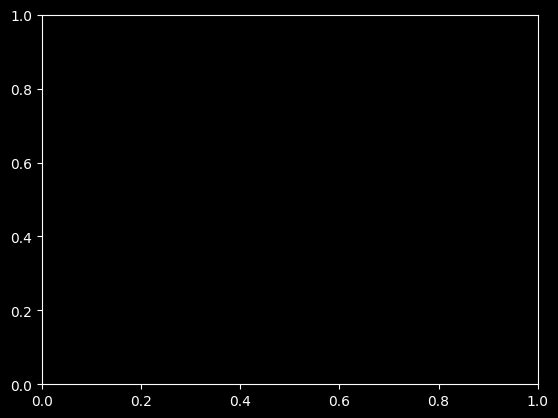

In [2]:
import matplotlib.pyplot as plt

plt.plot(list(result.keys()), [v.data["metric_Energy"].min() for v in result.values()])
plt.show()